# Simple RGB image workflow

Made by: Anna Casto

Updated: April 16, 2023

This tutorial shows basic steps for analyzing an RGB image of a single plant. Many more options are available at each step, if needed. Some of these are illustrated in the tutorial: Single Plant RGB Image Workflow

In [2]:
import os

# Detect notebook environment
def detect_notebook_environment():
    if 'COLAB_GPU' in os.environ:
        print('Google Colaboratory detected.')
        %pip install "altair>=5" ipympl plantcv
        
        # Give access and mount your Google Drive (need a Google Account)
        from google.colab import drive
        drive.mount('/content/gdrive')
        
        # Enable widget feature with matplotlib
        from google.colab import output
        output.enable_custom_widget_manager()
        
        #View working directory, may need to change
        %pwd
    else:
        print('Binder detected.')

environment = detect_notebook_environment()

Binder detected.


In [3]:
# If working in Binder, widget may not be functioning
# %matplotlib inline
%matplotlib widget
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

In [4]:
# Input/output options
args = WorkflowInputs(
    images=["./img/1_B73_sand_C_2023-04-14_10_19_07.jpg"],
    names="image",
    result="example_results_file.csv",
    outdir=".",
    writeimg=True,
    debug="plot"
    )

In [5]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 50
pcv.params.text_thickness = 20

#### Read in the image. The path to the image was set above in the input/output options section.

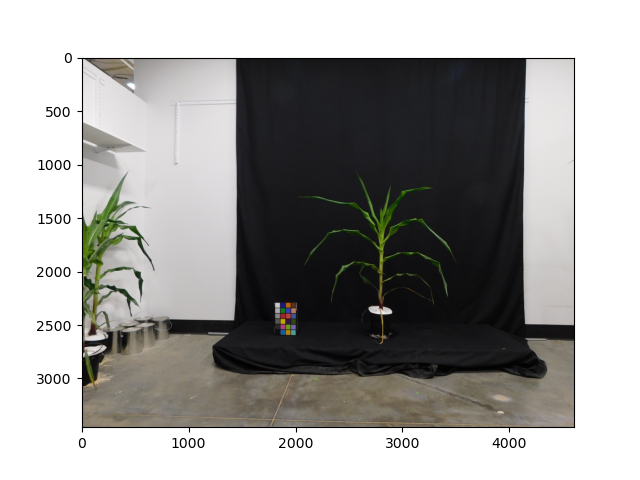

In [48]:
# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image, mode = "native")

#### Crop image if necessary. 
This is optional but can help if there are many extra objects around the object you're interested in. 

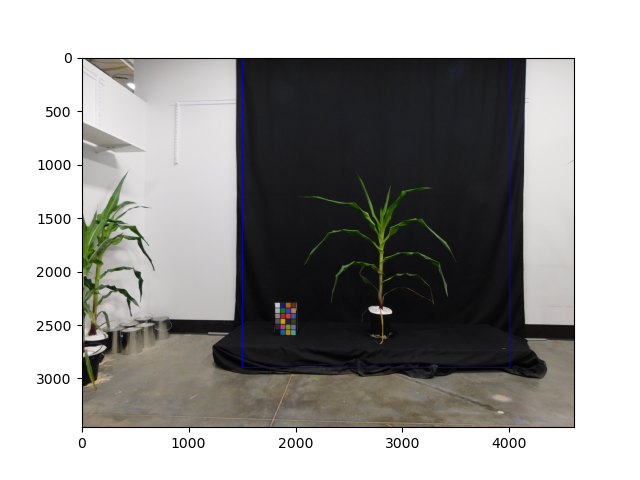

In [7]:
crop_img = pcv.crop(img=img, x=1500, y=0, h=2900, w=2500)

#### The visualize.colorspaces function allows you to look at the color space options for masking. 
Choose the colorspace in which the plant is most distinct from the backgound

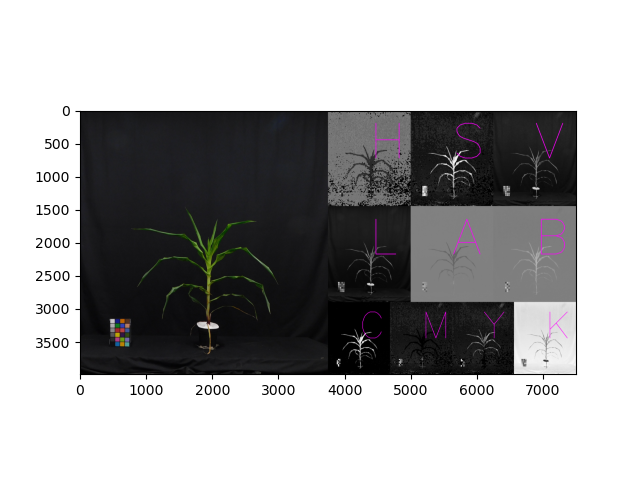

In [9]:
colorspace_img = pcv.visualize.colorspaces(rgb_img=crop_img)

#### Convert the RGB image to LAB and select the B channel

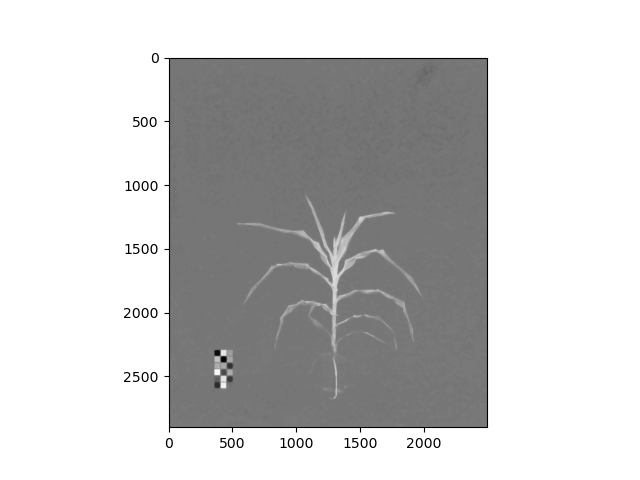

In [13]:
b_img = pcv.rgb2gray_lab(rgb_img=crop_img, channel='b')

#### Create binary image from a gray image based on threshold values targeting light objects in the image.
Creating a histogram of the pixel insenity of the b channel image gives us an idea of what value to set the threshold to.
The histogram is for visualizatin only. It isn't needed for the analysis.

In [47]:
# Examine signal distribution within an image
# prints out an image histogram of signal within image
hist_figure1, hist_data1 = pcv.visualize.histogram(img = b_img, hist_data=True)

alt.Chart(...)

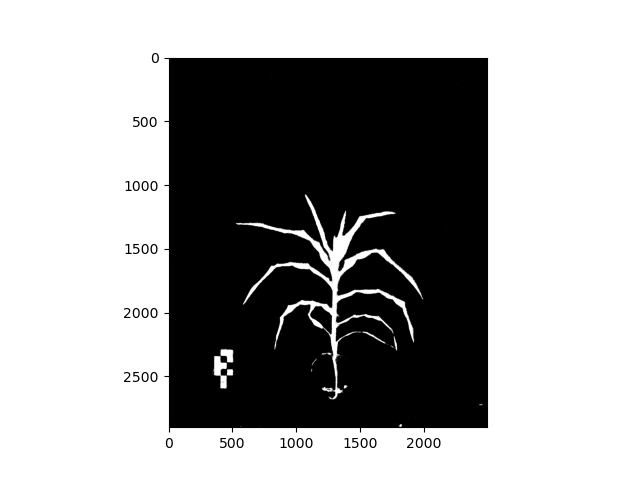

In [34]:
thresh_mask = pcv.threshold.binary(gray_img=b_img, threshold=130, object_type='light')

#### Cleaning up the mask
There are several options for cleaning up and adjusting our mask (fill, fill_holes, dilate, erode, etc).
Here we will just use fill to fill in small objects.

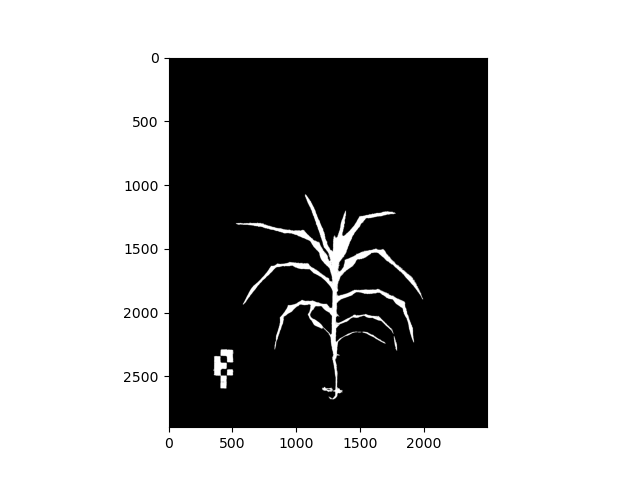

In [36]:
# fill in small objects
fill_mask = pcv.fill(bin_img=thresh_mask, size=1000)

#### Define the region of interest (ROI).
The ROI should include the plant but avoid the color card and other objects. 
There are many options for ROI shapes (rectangle, circle, multi, custom). Here we will just use rectangle.

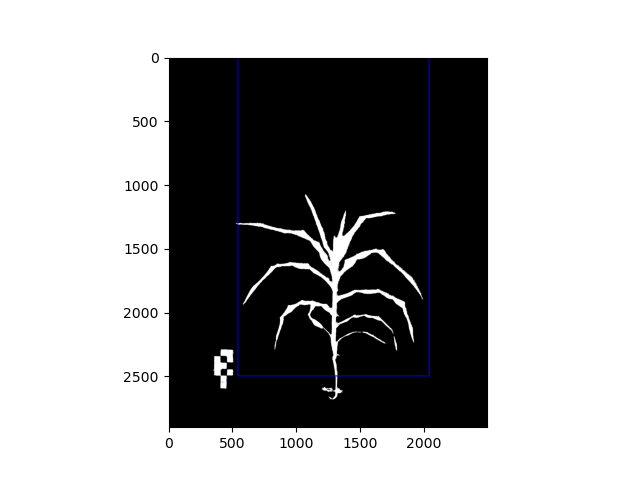

In [39]:
# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 

roi = pcv.roi.rectangle(img=fill_mask, x=540, y=0, h=2500, w=1500)

Make a new filtered mask that only keeps the plant in your ROI and not objects outside of the ROI.

We have set to partial here so that if a leaf extends outside of your ROI it will still be selected.


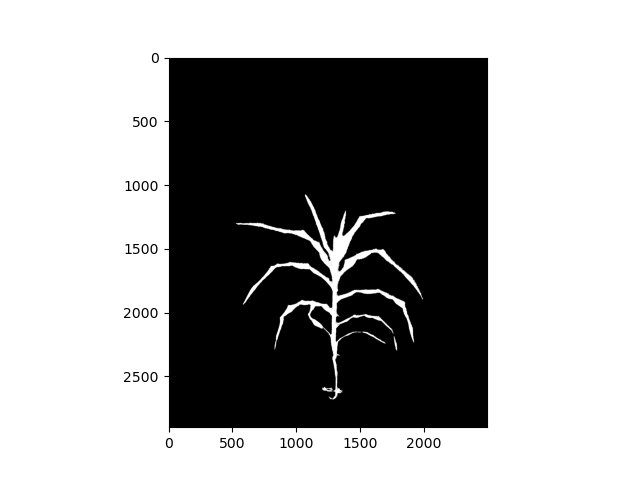

In [44]:
# Inputs:
#    mask            = the clean mask you made above
#    roi            = the region of interest you specified above
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)

kept_mask  = pcv.roi.filter(mask=fill_mask, roi=roi, roi_type='partial')

# Analysis

Analyze shape and color. The data gets stored to an Outputs class automatically.

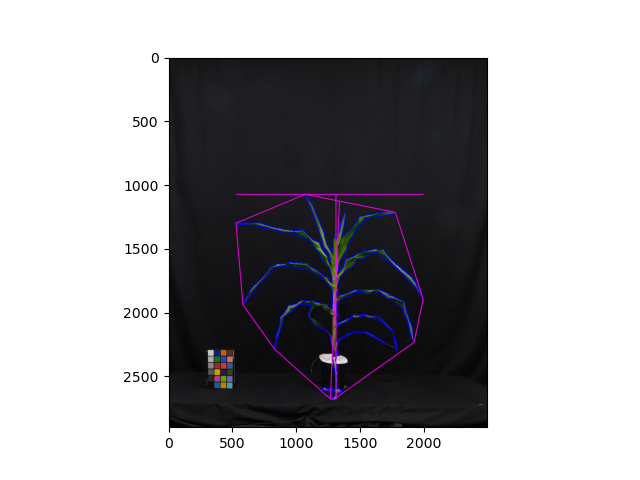

In [45]:
# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=crop_img, labeled_mask=kept_mask)

In [46]:
# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#                 This is the data to be printed to the SVG histogram file  
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze.color(rgb_img=crop_img, labeled_mask=kept_mask, colorspaces='all', label="default")

alt.FacetChart(...)

# Save Results

In [ ]:
#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename=args.result)